# DM - Clustering analysis [TASK 2]

In [1]:
import json
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import fetch_preprocessed_dataset, store_preprocessed_dataset
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

import sys
import logging as lg

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

/tmp/ipykernel_294053/1311723295.py:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
users = pd.read_json('total_users.json')

user_num = users[
    ['statuses_count', 'bot', 'tweets_num', 'tweets_2020_num', 'tweets_total_num', 'likes_num', 'comments_num', 'ratio_tweets_likes', 'entropy', 'texts_total_length', 'texts_special_chars_length']
].astype({'bot': 'int64'}).dropna()

In [3]:
scaler = StandardScaler()
scaler.fit(user_num.values)

StandardScaler()

In [4]:
user_num.values # first values

array([[7.600000e+01, 1.000000e+00, 0.000000e+00, ..., 1.588350e-05,
        7.484000e+03, 1.713000e+03],
       [5.400000e+01, 0.000000e+00, 0.000000e+00, ..., 1.156790e-05,
        7.276000e+03, 1.606000e+03],
       [5.000000e+01, 1.000000e+00, 1.000000e+00, ..., 1.096980e-05,
        1.135950e+05, 2.441400e+04],
       ...,
       [3.024000e+03, 0.000000e+00, 0.000000e+00, ..., 4.616328e-04,
        1.161890e+05, 2.549400e+04],
       [4.200000e+01, 1.000000e+00, 0.000000e+00, ..., 9.158700e-06,
        6.049000e+03, 1.370000e+03],
       [5.279000e+03, 0.000000e+00, 0.000000e+00, ..., 7.608898e-04,
        1.784080e+05, 3.866400e+04]])

In [5]:
scaled_values = scaler.transform(user_num.values) # first values scaled
scaled_values

array([[-0.32854803,  0.99608931, -0.16733899, ..., -0.38903223,
        -0.38539881, -0.3822764 ],
       [-0.32963328, -1.00392604, -0.16733899, ..., -0.39124694,
        -0.38652161, -0.38491458],
       [-0.3298306 ,  0.99608931,  4.96827344, ..., -0.39155388,
         0.187396  ,  0.17743761],
       ...,
       [-0.18312344, -1.00392604, -0.16733899, ..., -0.16027965,
         0.2013986 ,  0.204066  ],
       [-0.33022524,  0.99608931, -0.16733899, ..., -0.39248331,
        -0.39314504, -0.39073338],
       [-0.07188448, -1.00392604, -0.16733899, ..., -0.00670496,
         0.53726124,  0.52878444]])

In [6]:
scaler.inverse_transform(scaled_values) # first values scaled

array([[7.600000e+01, 1.000000e+00, 0.000000e+00, ..., 1.588350e-05,
        7.484000e+03, 1.713000e+03],
       [5.400000e+01, 0.000000e+00, 0.000000e+00, ..., 1.156790e-05,
        7.276000e+03, 1.606000e+03],
       [5.000000e+01, 1.000000e+00, 1.000000e+00, ..., 1.096980e-05,
        1.135950e+05, 2.441400e+04],
       ...,
       [3.024000e+03, 0.000000e+00, 0.000000e+00, ..., 4.616328e-04,
        1.161890e+05, 2.549400e+04],
       [4.200000e+01, 1.000000e+00, 0.000000e+00, ..., 9.158700e-06,
        6.049000e+03, 1.370000e+03],
       [5.279000e+03, 0.000000e+00, 0.000000e+00, ..., 7.608898e-04,
        1.784080e+05, 3.866400e+04]])

## KMeans

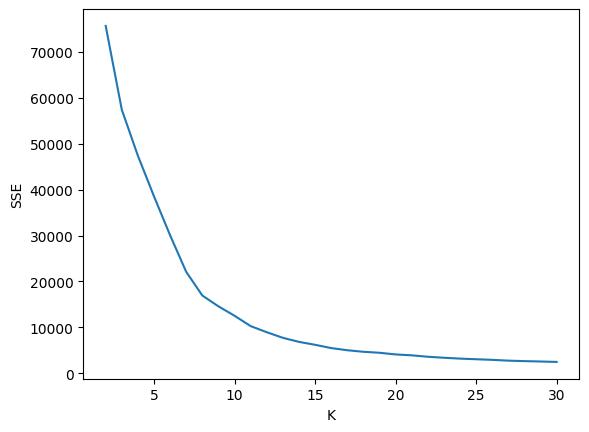

In [7]:
sse_list = []
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled_values)

    sse = kmeans.inertia_
    sse_list.append(sse)

plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.show()

In [8]:
kmeans = KMeans(n_clusters=10, n_init=10, max_iter=100)
kmeans.fit(scaled_values)

print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(scaled_values, kmeans.labels_))
print('Separation %s' % metrics.davies_bouldin_score(scaled_values, kmeans.labels_))

SSE 12527.437140256468
Silhouette 0.6540438983636028
Separation 0.5155311626493825


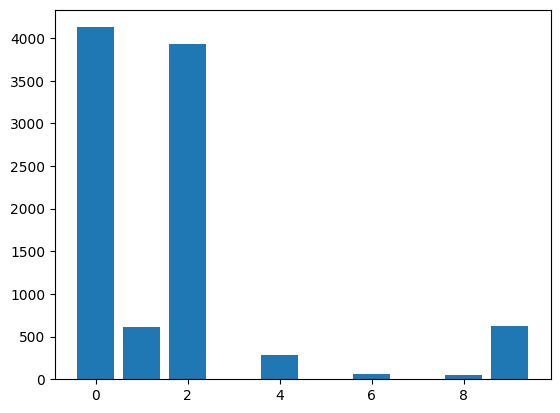

In [9]:
labels_distribution = np.unique(kmeans.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

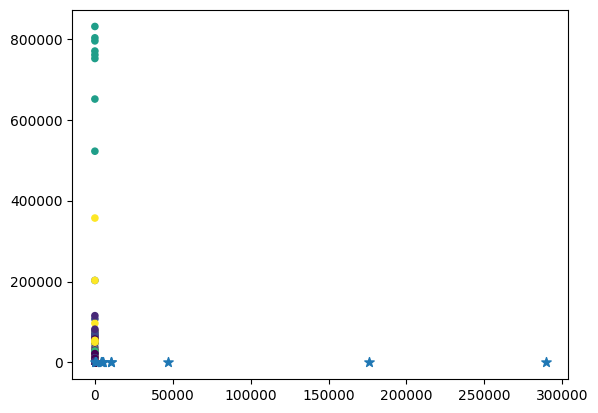

In [70]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(user_num['tweets_num'], user_num['likes_num'], c=kmeans.labels_, s=20)
plt.scatter(centers[:, 0], centers[:, 1], s=50, marker='*')
plt.show()

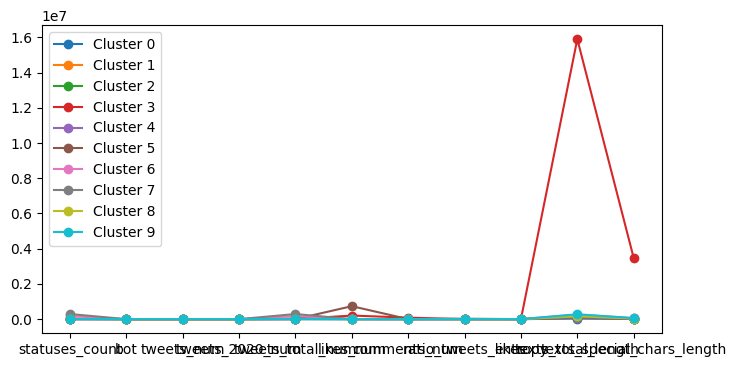

In [11]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(0, len(user_num.columns)), user_num.columns)
plt.legend(fontsize=10)
plt.show()

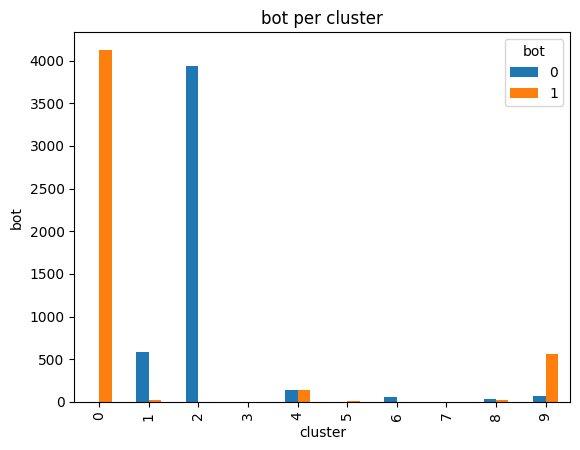

In [12]:
users_pct = pd.crosstab(kmeans.labels_, user_num['bot'])

users_pct.plot(kind='bar', stacked=False,
                   title='bot per cluster')
plt.xlabel('cluster')
plt.ylabel('bot')
plt.show()

## DBSCAN

In [13]:
dist = pdist(user_num, 'euclidean') #pair wise distance
dist = squareform(dist)
print(dist)

[[     0.            236.05389215 108512.37935657 ... 111354.68492491
    1476.24320574 175027.76455912]
 [   236.05389215      0.         108738.16940348 ... 111581.7659171
    1249.61276502 175254.79436426]
 [108512.37935657 108738.16940348      0.         ...   5060.70479929
  109987.3722178   66772.00351568]
 ...
 [111354.68492491 111581.7659171    5060.70479929 ...      0.
  112830.58339772  63677.49385708]
 [  1476.24320574   1249.61276502 109987.3722178  ... 112830.58339772
       0.         176503.54921936]
 [175027.76455912 175254.79436426  66772.00351568 ...  63677.49385708
  176503.54921936      0.        ]]


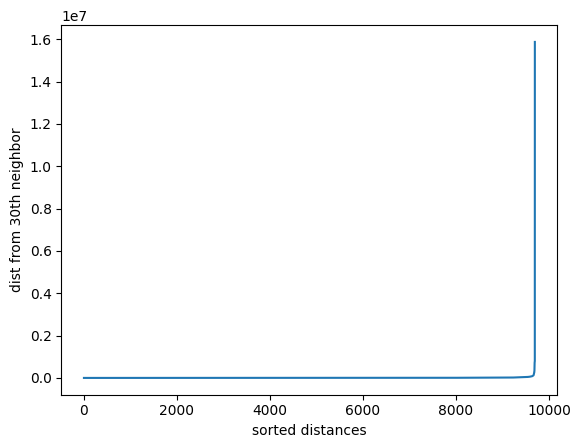

In [71]:
k = 30
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])
    
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k)
plt.xlabel('sorted distances')
plt.show()

In [15]:
dbscan = DBSCAN(eps=4, min_samples=30)
dbscan.fit(scaled_values)

print('Silhouette %s' % silhouette_score(scaled_values, kmeans.labels_))
print('Separation %s' % metrics.davies_bouldin_score(scaled_values, kmeans.labels_))

Silhouette 0.6540438983636028
Separation 0.5155311626493825


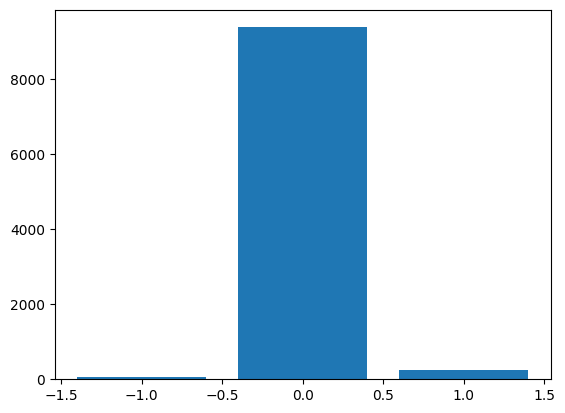

In [16]:
labels_distribution = np.unique(dbscan.labels_, return_counts=True)
plt.bar(labels_distribution[0], labels_distribution[1])
plt.show()

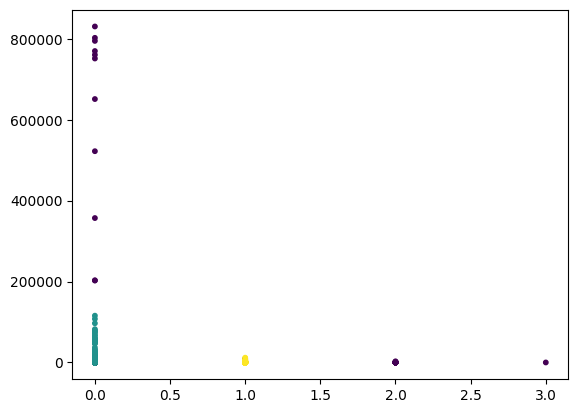

In [72]:
plt.scatter(user_num['tweets_num'], user_num['likes_num'], c=dbscan.labels_, s=10)
plt.show()

## Hierarchical

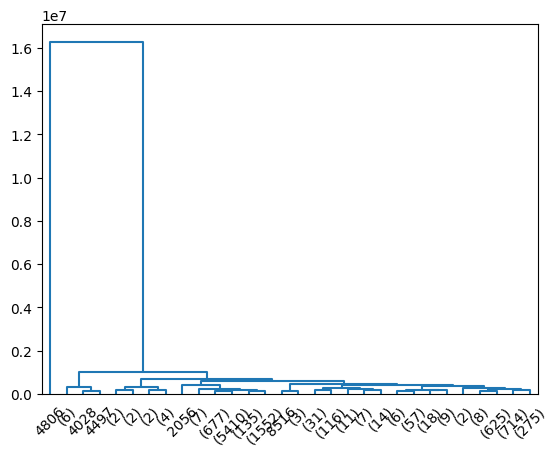

In [18]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

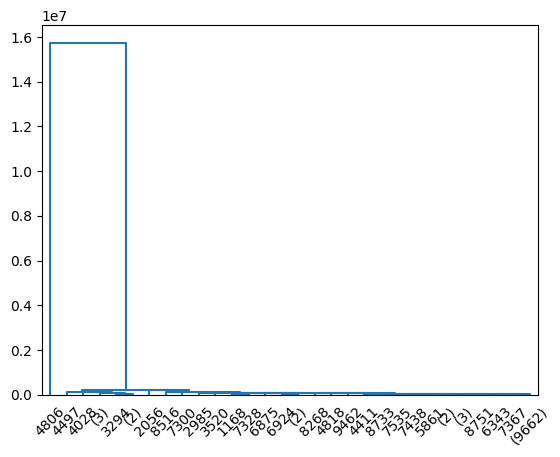

In [19]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

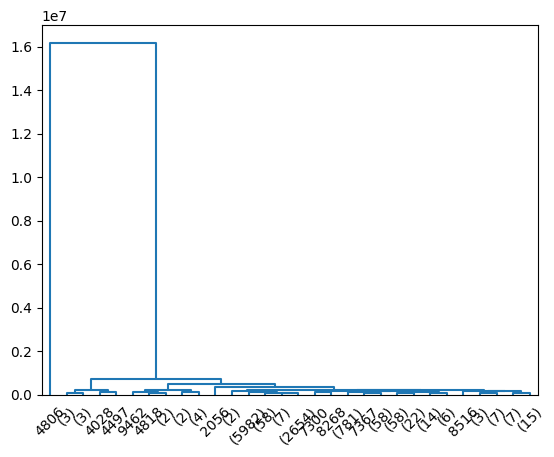

In [20]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

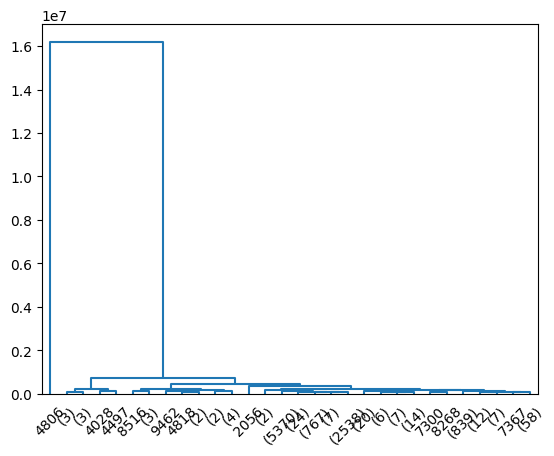

In [21]:
data_dist = pdist(user_num, metric='euclidean')
data_link = linkage(data_dist, method='centroid', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')

## XMeans

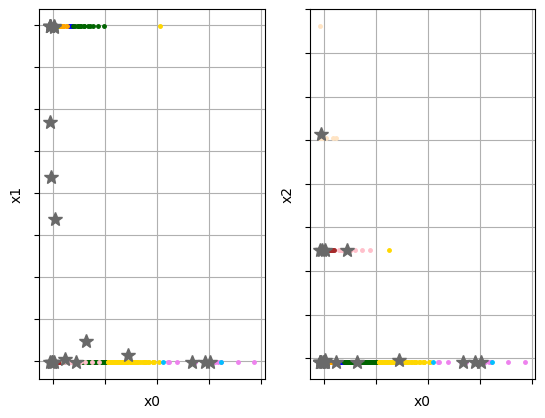

In [69]:
from pyclustering.cluster import cluster_visualizer, cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

sample = scaled_values
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(sample, amount_initial_centers).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(sample, initial_centers, 20)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
# Visualize clustering results
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample.tolist())
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show(pair_filter=[[0, 1], [0, 2]])